# Fourier Series Seasonal Cycle of Temperature
This is inspired by the Roach 2023 paper, looking at fitting the seasonal cycle of temperature using Fourier Series fit to insolation and temperature, rather than assuming just a single sinusoid (annual harmonic).

In particular the annual harmonic is problematic at the poles, where there is polar night and in the subptropics where the maxima is broader than the minima.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p_water, rho_water, R, c_p, Stefan_Boltzmann
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
import colorcet
from scipy.ndimage import convolve1d
import matplotlib
from matplotlib.colors import ListedColormap

2023-09-05 09:55:19,724 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


## Get datasets

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe']
# Load dataset
exp_names = ["5","10","15","20","30"]
exp_dir = ['aquaplanet/vary_obliquity/'] * len(exp_names)
# Insert default earth experiment, with obliq=23.439
exp_names.insert(4, 'k=1')
exp_dir.insert(4, 'tau_sweep/aquaplanet/')

n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
obliq = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir[i] + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir[i] + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        obliq += [namelist['astronomy_nml']['obliq']]
    except KeyError:
        obliq += [23.439]       # if no astronomy namelist, obliquity is set to default earth value
    mixed_layer_depth = namelist['mixed_layer_nml']['depth']

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [331]:
# Consider a single location
lat_use = 50
lon_use = None
# lon_use = 300
use_time_start = 360*2
ds_single_loc = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
    ds_use = ds_use.sel(lat=lat_use, method='nearest')
    if lon_use == None:
        ds_use = ds_use.mean(dim='lon')
    else:
        ds_use = ds_use.sel(lon=lon_use, method='nearest')
    ds_use = annual_mean(ds_use)
    ds_single_loc += [ds_use.load()]        # take zonal average
# ds_lat = ds.sel(lat=loc['lat'], method='nearest')
# # Update location with actual latitude
lat_use = round(float(ds_single_loc[0].lat), 1)
p_low_level = float(ds_single_loc[0].pfull) * 100

100%|██████████| 6/6 [01:12<00:00, 12.01s/it]


In [332]:
# These functions compute the analytical fourier coefficients
n_year_days = 360
def fourier_series(time, coefs_amp, coefs_phase):
    n_harmonics = len(coefs_amp)
    ans = 0.5 * coefs_amp[0]
    for n in range(1, n_harmonics):
        ans += coefs_amp[n] * np.cos(2*n*np.pi*time/n_year_days - coefs_phase[n-1])
    return ans

def get_fourier_coef(var, time, n, T=n_year_days, integ_method='spline'):
    # Computes the analytical fourier coefficients for the n harmonic of a given function
    # With integrate method = spline works very well i.e. fit spline then use spline.integrate functionality
    # Otherwise, there are problems with the integration especially at the limits e.g. t=0 and t=T.
    if integ_method == 'spline':
        var = np.append(var, var[0])
        time = np.append(time, time[-1]+1)
    if n == 0:
        if integ_method == 'spline':
            spline = CubicSpline(time,var, bc_type='periodic')
            return 2/T * spline.integrate(0, T)
        else:
            return 2/T * integrate.simpson(var, time)
    else:
        # constants for acos(t) + bsin(t) form
        if integ_method == 'spline':
            spline = CubicSpline(time,var * np.cos(2*n*np.pi*time/T), bc_type='periodic')
            cos_coef = 2/T * spline.integrate(0, T)
            sin_curve = var * np.sin(2*n*np.pi*time/T)
            sin_curve[-1] = 0       # Need first and last value to be the same to be periodic spline
                                    # usually have last value equal 1e-10 so not equal
            spline = CubicSpline(time,sin_curve, bc_type='periodic')
            sin_coef = 2/T * spline.integrate(0, T)
        else:
            cos_coef = 2/T * integrate.simpson(var * np.cos(2*n*np.pi*time/T), time)
            sin_coef = 2/T * integrate.simpson(var * np.sin(2*n*np.pi*time/T), time)
        # constants for Acos(t-phi) form 
        phase_coef = np.arctan(sin_coef/cos_coef)
        amp_coef = cos_coef / np.cos(phase_coef)
        return amp_coef, phase_coef

def get_fourier_fit(time, var, n_harmonics, T=n_year_days, integ_method='spline'):
    # Returns the fourier fit of a function using a given number of harmonics
    amp_coefs = np.zeros(n_harmonics+1)
    phase_coefs = np.zeros(n_harmonics)
    amp_coefs[0] = get_fourier_coef(var, time, 0, T, integ_method)
    for i in range(1, n_harmonics+1):
        amp_coefs[i], phase_coefs[i-1] = get_fourier_coef(var, time, i, T, integ_method)
    return fourier_series(time, amp_coefs, phase_coefs), amp_coefs, phase_coefs

In [333]:
# Functions to fit smooth spline to temperature and insolation data
def get_maxima_date_from_spline(spline, thresh=None, n_maxima=2):
    """
    Given a spline, this returns the dates (x variable) corresponding to the maxima.
    
    Args:
        spline: 
        thresh: Only keep maxima with values above this.
        n_maxima: Keep at most this many maxima, if more than this then will only keep highest.
    """
    extrema_date = spline.derivative().roots(extrapolate=False)
    maxima_date = extrema_date[spline(extrema_date, 2) < 0]         # maxima have a negative second derivative
    maxima_values = spline(maxima_date)
    if thresh is not None:
        # Only keep maxima with value above threshold
        maxima_date = maxima_date[maxima_values > thresh]
        maxima_values = maxima_values[maxima_values > thresh]
    if len(maxima_date) > n_maxima:
        keep_ind = np.argsort(maxima_values)[-n_maxima:]
        maxima_date = maxima_date[keep_ind]
    return maxima_date

def get_sw_temp_max_date(time, swdn_sfc, t_surf, sw_spacing=90, temp_spacing=20, max_maxima = 2):
    """
    Finds the dates of maximum insolation and temperature, given some smoothing is performed first.
    Also returns the splines themselves.
    
    Args:
        time: Array of time in days
        swdn_sfc: Shortwave radiation reaching surface at each time.
        t_surf: Surface temperature at each time.
        sw_spacing: Interval of coordinates to use to fit to shortwave radiation. Smaller equals more accurate fit.
        temp_spacing: Interval of coordinates to use to fit to temperature. Smaller equals more accurate fit.
        max_maxima: Will return at most this many maxima.
    """
    # Make so last element of arrays equal first as periodic
    time = np.append(time, time[-1]+1)
    swdn_sfc = np.append(swdn_sfc, swdn_sfc[0])
    t_surf = np.append(t_surf, t_surf[0])
    # Get spline
    spline_sw = CubicSpline(time[::sw_spacing], swdn_sfc[::sw_spacing], bc_type='periodic')
    spline_temp = CubicSpline(time[::temp_spacing], t_surf[::temp_spacing], bc_type='periodic')
    # Get maxima dates from spline - ensure maxima is above mean
    maxima_date_sw = get_maxima_date_from_spline(spline_sw, np.mean(swdn_sfc), max_maxima)
    maxima_date_temp = get_maxima_date_from_spline(spline_temp, np.mean(t_surf), max_maxima)
    return  maxima_date_sw, maxima_date_temp, spline_sw, spline_temp

In [334]:
# Sort max_date arrays where have two maxima for each location
def sort_max_date(max_date, n_day_year=n_year_days, sort_axis=-1):
    """
    Takes array of maxima dates which are cyclic and sorts them so get continuous progression along each axis 
    referring to a different maxima.
    
    Args:
        max_date: [n_lat x n_lon x n_maxima] Array of dates, given by an integer referring to the day of the year
            This assumes n_maxima = 2
        n_day_year: Number of days in a year
    """
    max_date = np.sort(max_date, axis=sort_axis)                        # Sort so have second maxima as latest
    # Where latest maxima is in second half of year, make negative, so it comes before the first maxima
    max_date[np.where(max_date[:, :, 1]>n_day_year/2)] -= [0, n_day_year-1]  
    # Now sort the maxima so get continuous evolution of both
    max_date = np.sort(max_date, axis=sort_axis)
    # Make all dates positive
    max_date[max_date<0] = max_date[max_date<0]+(n_day_year-1)
    # Make all dates in correct range
    max_date = max_date % (n_day_year-1)
    return max_date

## Single Location
Below I fit a fourier series as well as a spline to both the insolation and the surface temperature. The spline fit should be taken as ground truth.

At the poles, multiple harmonics in the fourier series are required to capture the insolation because it is not sinusoidal.

For the surface temperature, multiple harmonics are required in the tropics where there are two maxima. The fit and thus postion of maxima obviously becomes better with more harmonics. At the poles, there is only one maxima but the variation is not sinusoidal, so more than one harmonic is required as well.

For the harmonics, there is an analytical equation for the [fourier coefficients](https://www.bragitoff.com/2021/05/fourier-series-coefficients-and-visualization-python-program/).

In [335]:
# Find maxima using spline fitting i.e. ground truth
time_array = ds_single_loc[0].time-0.5
max_date_sw_spline_single = np.zeros((n_exp, 2))
max_date_temp_spline_single = np.zeros((n_exp, 2))
sw_spline_single = [0] * n_exp
temp_spline_single = [0] * n_exp
for i in range(n_exp):
    max_date_sw_spline_single[i], max_date_temp_spline_single[i], sw_spline_single[i], temp_spline_single[i] = get_sw_temp_max_date(
        time_array, ds_single_loc[i].swdn_sfc, ds_single_loc[i].t_surf)

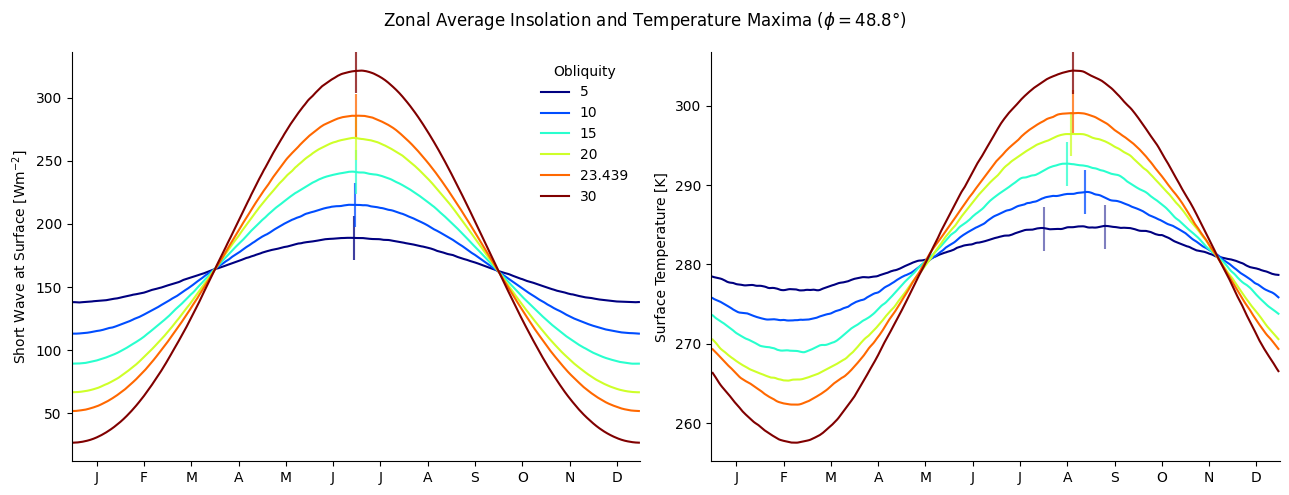

In [336]:
# linestyle_harmonic = [':', '-', '--', '-.']
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
color_seq_obliq = plt.cm.jet(np.linspace(0,1,n_exp))
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1,2, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
for i in range(n_exp):
    ax[0].plot(time_array, ds_single_loc[i].swdn_sfc, color=color_seq_obliq[i], label=obliq[i])
    ax[1].plot(time_array, ds_single_loc[i].t_surf, color=color_seq_obliq[i])
    for j in range(max_date_sw_spline_single.shape[1]):
        ax[0].scatter(max_date_sw_spline_single[i, j], sw_spline_single[i](max_date_sw_spline_single[i, j]), 
                      color=color_seq_obliq[i], alpha=0.5, marker='|', s=1000)
        ax[1].scatter(max_date_temp_spline_single[i, j], temp_spline_single[i](max_date_temp_spline_single[i, j]), 
                      color=color_seq_obliq[i], alpha=0.5, marker='|', s=1000)
        
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].legend(frameon=False, title='Obliquity')
ax[0].set_ylabel('Short Wave at Surface [Wm$^{-2}$]')
ax[1].set_ylabel('Surface Temperature [K]')
fig.suptitle(f"Zonal Average Insolation and Temperature Maxima ($\phi={lat_use}\degree$)")
plt.tight_layout()

## Get Empirical Hottest Date
Plot how $\lambda$ and $F_2/F_1$ independently influence the date of the hottest day of the year.

It appears that they both change as obliquity is increased in a way to make the hottest date earlier in the year. I.e. $\lambda$ increases with obliquity, mainly due to the effect of latent heat, whereas $F_2/F_1$ becomes more negative as obliquity is increased.

In [337]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)

def get_temp_fourier_coefs(sw_fourier_amp, sw_fourier_phase, lambda_const, heat_capacity, n_year_days=n_year_days):
    # This assumes the equation CdT/dt = F(t) - lambda*T
    # It then solves differential equation for each harmonic independently
    freq = 1/(n_year_days*24*60**2)
    amp_coef = np.zeros_like(sw_fourier_amp)
    phase_coef = np.zeros_like(sw_fourier_phase)
    amp_coef[0] = lambda_const * sw_fourier_amp[0]
    for i in range(len(phase_coef)):
        phase_coef[i] = np.arctan((lambda_const*np.tan(sw_fourier_phase[i]) + 2*(i+1)*np.pi*freq*heat_capacity)/
                                  (lambda_const - 2*(i+1)*np.pi*freq*heat_capacity*np.tan(sw_fourier_phase[i])))
        amp_coef[i+1] = sw_fourier_amp[i+1]*np.cos(sw_fourier_phase[i])/(
                2*(i+1)*np.pi*freq*heat_capacity*np.sin(phase_coef[i])+lambda_const * np.cos(phase_coef[i]))
    return amp_coef, phase_coef

def get_lambda_empirical(dataset, temp_thresh_quant=0):
    # Give temp_anom_thresh, so you can choose to comptue lambda using only the hotter days, seen
    # as we are interested in the date of the hottest day of the year, so feedback on hot days is likely important.
    # 0 means use all days
    gamma_flux = dataset.lwdn_sfc - dataset.lwup_sfc - dataset.flux_lhe - dataset.flux_t 
    temp_anomaly = dataset.t_surf-np.mean(dataset.t_surf)
    use = np.where(temp_anomaly>=temp_anomaly.quantile(temp_thresh_quant))
    lambda_const, beta_const, r_squared, _, _ = scipy.stats.linregress(temp_anomaly[use],
                                                                       (gamma_flux - np.mean(gamma_flux))[use])
    return -lambda_const, beta_const, r_squared

def get_temp_maxima_date_lambda(dataset, lambda_type='empirical', zero_phase=True, n_harmonics=2, time=time_array, 
                                heat_capacity=heat_capacity, n_year_days=n_year_days, temp_thresh_quant=0):
    if lambda_type == 'empirical':
        lambda_const = get_lambda_empirical(dataset, temp_thresh_quant)[0]
    else:
        raise ValueError('lambda_type must be empirical or theory')
    sw_amp_coefs, sw_phase_coefs = get_fourier_fit(time_array, dataset.swdn_sfc, n_harmonics)[1:3]
    if zero_phase:
        sw_phase_coefs[:] = 0
    sw_amp_coefs[0] = 0             # First coefficient is zero as only interested in where maxima is not actual value
    temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(sw_amp_coefs, sw_phase_coefs, lambda_const, heat_capacity, n_year_days)
    temp_fourier_approx = fourier_series(time_array, temp_amp_coefs, temp_phase_coefs)
    temp_approx_spl = CubicSpline(np.append(time, time[-1]+1), np.append(temp_fourier_approx, temp_fourier_approx[0]), bc_type='periodic')
    maxima_date = np.zeros(2)
    maxima_date[:] = get_maxima_date_from_spline(temp_approx_spl)
    return lambda_const, sw_amp_coefs, maxima_date

In [338]:
def get_temp_maxima_date_from_lambda(sw_amp_ratio_array, lambda_const_array, time=time_array,
                                     hemisphere = 'north', heat_capacity=heat_capacity, n_year_days=n_year_days, 
                                     verbose_min_vals=100):
    # THIS ASSUMES THAT THE PHASE FOURIER COEFFICIENTS FOR SHORTWAVE ARE ZERO
    time = np.append(time, time[-1]+1)
    maxima_date = np.zeros((len(sw_amp_ratio_array), len(lambda_const_array), 2))
    sw_phase_coefs = np.zeros(2)        # assume shortwave phase shift is zero for all harmonics to simplify and makes little difference
    sw_amp_coefs = np.zeros(3)          # First coefficient is zero as only interested in where maxima is not actual value

    # Negative value means northern hemisphere (minima in January), negative means southern hemisphere (maxima in January)
    if hemisphere == 'north':
        sw_amp_coefs[1] = -1         # Note the value of this is irrelevent as only the ratio affects the date of the maxima.
    else:
        sw_amp_coefs[1] = 1                         
    with tqdm(total=np.product(maxima_date.shape[:2]), position=0, leave=True, 
              disable=False if np.product(maxima_date.shape[:2])>verbose_min_vals else True) as pbar: 
        for i, sw_amp_ratio in enumerate(sw_amp_ratio_array):
            sw_amp_coefs[2] = sw_amp_coefs[1] * sw_amp_ratio
            for j, lambda_const in enumerate(lambda_const_array):
                temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(sw_amp_coefs, sw_phase_coefs, lambda_const, heat_capacity,
                                                                          n_year_days)
                temp_fourier_approx = fourier_series(time_array, temp_amp_coefs, temp_phase_coefs)
                temp_approx_spl = CubicSpline(time, np.append(temp_fourier_approx, temp_fourier_approx[0]), bc_type='periodic')
                maxima_date[i, j] = get_maxima_date_from_spline(temp_approx_spl)
                pbar.update(1)
    return maxima_date

def get_t_max_lambda_partial_deriv(lambda_use, sw_ratio_use, spacing=0.05, n_array=10, deriv_use=1):
    # Compute derivative of date with respect to lambda
    lambda_deriv_array = np.arange(lambda_use - n_array * spacing, lambda_use + n_array * spacing, spacing)
    lambda_date_deriv_array = get_temp_maxima_date_from_lambda(np.asarray([sw_ratio_use]), lambda_deriv_array)[0, :, 1]
    # plt.plot(lambda_deriv_array, lambda_date_deriv_array)
    return float(CubicSpline(lambda_deriv_array, lambda_date_deriv_array).derivative(deriv_use)(lambda_use))


def get_t_max_sw_ratio_partial_deriv(sw_ratio_use, lambda_use, spacing=0.01, n_array=10, deriv_use=1):
    # Compute derivative of date with respect to sw_ratio
    sw_ratio_deriv_array = np.arange(sw_ratio_use - n_array * spacing, sw_ratio_use + n_array * spacing, spacing)
    sw_ratio_date_deriv_array = get_temp_maxima_date_from_lambda(sw_ratio_deriv_array, np.asarray([lambda_use]))[:, 0,
                                1]
    # plt.plot(sw_ratio_deriv_array, sw_ratio_date_deriv_array)
    return float(CubicSpline(sw_ratio_deriv_array, sw_ratio_date_deriv_array).derivative(deriv_use)(sw_ratio_use))

In [339]:
lambda_temp_quant_thresh = 0.5
lambda_empirical = np.zeros(n_exp)
sw_harmonic_ratio = np.zeros(n_exp)
max_date_temp_empirical = np.zeros((n_exp, 2))
for i in range(n_exp):
    lambda_empirical[i], sw_amp_use, max_date_temp_empirical[i] = get_temp_maxima_date_lambda(ds_single_loc[i],
                                                                                              temp_thresh_quant=lambda_temp_quant_thresh)
    sw_harmonic_ratio[i] = sw_amp_use[2]/sw_amp_use[1]
    
lambda_empirical_obliq_spline = CubicSpline(obliq, lambda_empirical)
sw_ratio_obliq_spline = CubicSpline(obliq, sw_harmonic_ratio)

In [340]:
# lat_taylor_use_ind = numpy_indexed.indices(ds_global.lat, ds_global.lat[ds_global.lat>lat_taylor_min])
obliq_large_array = np.asarray(obliq)
obliq_large_array = np.linspace(obliq[0], obliq[-1], 100)
lambda_date_taylor_cont_seq = np.zeros_like(obliq_large_array, dtype=float)
sw_ratio_date_taylor_cont_seq = np.zeros_like(obliq_large_array, dtype=float)
with tqdm(total=len(obliq_large_array)-1, position=0, leave=True) as pbar:
    for i, obliq_use in enumerate(obliq_large_array[:-1]):
        lambda_date_taylor_cont_seq[i+1] = lambda_date_taylor_cont_seq[i] + \
                                       get_t_max_lambda_partial_deriv(lambda_empirical_obliq_spline(obliq_use),
                                                                      sw_ratio_obliq_spline(obliq_use)) * (
                                               lambda_empirical_obliq_spline(obliq_large_array[i+1])-lambda_empirical_obliq_spline(obliq_use))
        sw_ratio_date_taylor_cont_seq[i+1] = sw_ratio_date_taylor_cont_seq[i] + \
                                         get_t_max_sw_ratio_partial_deriv(sw_ratio_obliq_spline(obliq_use), 
                                                                        lambda_empirical_obliq_spline(obliq_use)) * (
                                               sw_ratio_obliq_spline(obliq_large_array[i+1])-sw_ratio_obliq_spline(obliq_use))
        pbar.update(1)

100%|██████████| 99/99 [00:03<00:00, 28.08it/s]


In [341]:
def get_lambda_empirical_breakdown(dataset, temp_thresh_quant=0):
    # Returns lambda for longwave, latent heat and sensible heat
    t_surf_anomaly = dataset.t_surf-np.mean(dataset.t_surf)
    use = np.where(t_surf_anomaly > t_surf_anomaly.quantile(temp_thresh_quant))
    lambda_const = np.zeros(3)
    beta_const = np.zeros(3)
    r_squared = np.zeros(3)
    for i, var in enumerate([dataset.lwdn_sfc-dataset.lwup_sfc, -dataset.flux_lhe, -dataset.flux_t ]):
        lambda_const[i], beta_const[i], r_squared[i] = scipy.stats.linregress(t_surf_anomaly[use], (var - np.mean(var))[use])[:3]
    return -lambda_const, beta_const, r_squared

lambda_breakdown_labels = ['Longwave', 'Latent Heat', 'Sensible Heat']
lambda_linestyles = [':', '--', '-.']
lambda_empirical_breakdown = np.zeros((n_exp, 3))
for i in range(n_exp):
    lambda_empirical_breakdown[i] = get_lambda_empirical_breakdown(ds_single_loc[i], temp_thresh_quant=lambda_temp_quant_thresh)[0]
    
lambda_empirical_breakdown_obliq_spline = [CubicSpline(obliq, lambda_empirical_breakdown[:, i]) for i  in range(3)]
lambda_breakdown_date_taylor_cont_seq = np.zeros((len(obliq_large_array), 3))
with tqdm(total=3*(len(obliq_large_array)-1), position=0, leave=True) as pbar:
    for i, obliq_use in enumerate(obliq_large_array[:-1]):
        lambda_grad = get_t_max_lambda_partial_deriv(lambda_empirical_obliq_spline(obliq_use), sw_ratio_obliq_spline(obliq_use))
        for j in range(3):
            lambda_breakdown_date_taylor_cont_seq[i+1, j] = lambda_breakdown_date_taylor_cont_seq[i, j] + \
                                            lambda_grad * (lambda_empirical_breakdown_obliq_spline[j](obliq_large_array[i+1]) -
                                                           lambda_empirical_breakdown_obliq_spline[j](obliq_use))
            pbar.update(1)

100%|██████████| 297/297 [00:01<00:00, 168.41it/s]


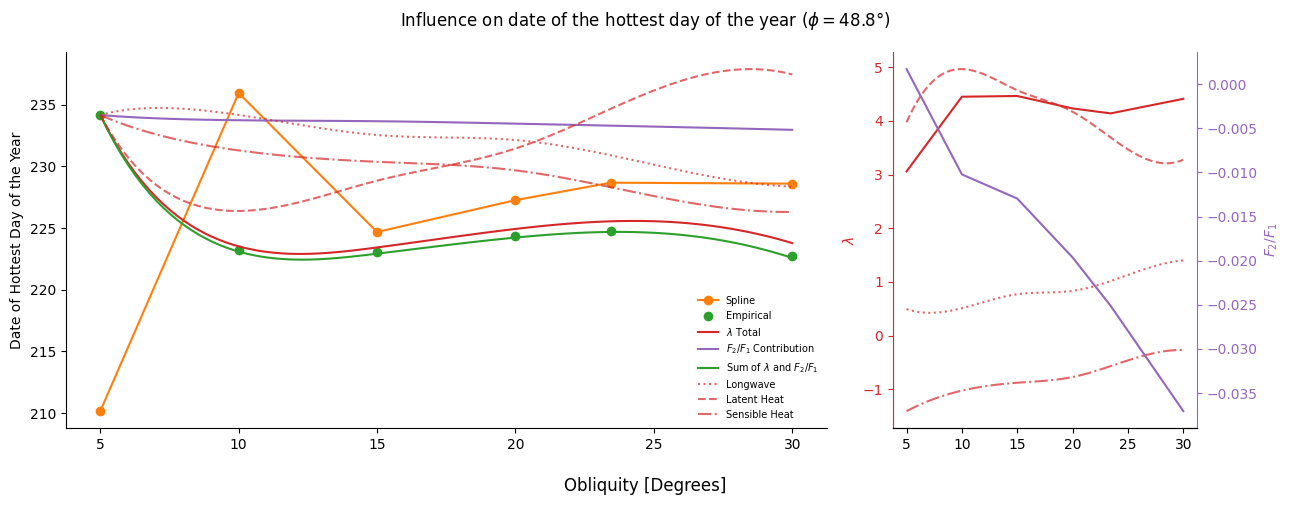

In [342]:
fig, ax = plt.subplots(1,2, figsize=(13, 5), sharex=True, width_ratios=[5,2])
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[0].plot(obliq, max_date_temp_spline_single[:, 0], '-o', color=default_colors[1], label='Spline')
ax[0].scatter(obliq, max_date_temp_empirical[:, 0], color=default_colors[2], label='Empirical')
ax[0].plot(obliq_large_array, max_date_temp_empirical[0, 0]+lambda_date_taylor_cont_seq, color=default_colors[3], 
           label='$\lambda$ Total')
ax[0].plot(obliq_large_array, max_date_temp_empirical[0, 0]+sw_ratio_date_taylor_cont_seq, color=default_colors[4], label='$F_2/F_1$ Contribution')
ax[0].plot(obliq_large_array, max_date_temp_empirical[0, 0]+sw_ratio_date_taylor_cont_seq+lambda_date_taylor_cont_seq,
           color=default_colors[2], label='Sum of $\lambda$ and $F_2/F_1$')
for i in range(3): 
    ax[0].plot(obliq_large_array, max_date_temp_empirical[0, 0]+lambda_breakdown_date_taylor_cont_seq[:, i], 
           color=default_colors[3], linestyle=lambda_linestyles[i], alpha=0.7, label=lambda_breakdown_labels[i])
    ax[1].plot(obliq_large_array, lambda_empirical_breakdown_obliq_spline[i](obliq_large_array), color=default_colors[3],
               linestyle=lambda_linestyles[i], alpha=0.7)
ax[0].legend(frameon=False, fontsize=7)

ax[0].set_ylabel('Date of Hottest Day of the Year')
fig.supxlabel('Obliquity [Degrees]')

ax[1].plot(obliq, lambda_empirical, color=default_colors[3])
ax[1].tick_params(axis='y', colors=default_colors[3])
ax[1].spines['left'].set_color(default_colors[3])
ax[1].set_ylabel('$\lambda$', color=default_colors[3])
ax2 = ax[1].twinx()
ax2.plot(obliq, sw_harmonic_ratio, color=default_colors[4])
ax2.spines[['top', 'left']].set_visible(False)
ax2.tick_params(axis='y', colors=default_colors[4])
ax2.spines['right'].set_color(default_colors[4])
ax2.set_ylabel('$F_2/F_1$', color=default_colors[4])
fig.suptitle(f"Influence on date of the hottest day of the year ($\phi={lat_use}\degree$)")
plt.tight_layout()

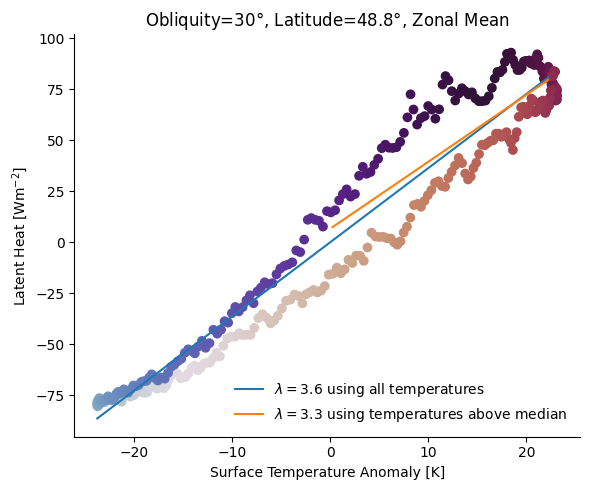

In [343]:
# Plot to show how lambda computed for latent heat
obliq_plot_ind = 5
ds_use = ds_single_loc[obliq_plot_ind]
fig, ax = plt.subplots(1,1, figsize=(6, 5))
ax.spines[['top', 'right']].set_visible(False)
ax.scatter(ds_use.t_surf-np.mean(ds_use.t_surf), ds_use.flux_lhe-np.mean(ds_use.flux_lhe), 
            c=time_array, cmap='twilight')
m, c = scipy.stats.linregress(ds_use.t_surf-np.mean(ds_use.t_surf), ds_use.flux_lhe-np.mean(ds_use.flux_lhe))[:2]
temp_plot_array = np.arange(ds_use.t_surf.min(),ds_use.t_surf.max(),1)-float(ds_use.t_surf.mean())
ax.plot(temp_plot_array,m*temp_plot_array+c, label=f'$\lambda={round(m,1)}$ using all temperatures')
use = ds_use.t_surf > ds_use.t_surf.quantile(0.5)
m, c = scipy.stats.linregress(ds_use.t_surf[use]-np.mean(ds_use.t_surf), ds_use.flux_lhe[use]-np.mean(ds_use.flux_lhe))[:2]
ax.plot(temp_plot_array[temp_plot_array>0],m*temp_plot_array[temp_plot_array>0]+c, label=f'$\lambda={round(m,1)}$ using temperatures above median')
ax.set_xlabel('Surface Temperature Anomaly [K]')
ax.set_ylabel('Latent Heat [Wm$^{-2}$]')
ax.legend(frameon=False)
ax.set_title(f'Obliquity={obliq[obliq_plot_ind]}$\degree$, Latitude={lat_use}$\degree$, '
             f'{"Zonal Mean" if lon_use==None else f"Longitude={lon_use}"}')
plt.tight_layout()